In [1]:
# import packages
from astropy.utils import data
from radio_beam import Beam
from astropy import units as u
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd
from scipy.stats.stats import pearsonr
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from math import log10, floor
import pickle
from astropy.table import Table
from statsmodels.stats.weightstats import DescrStatsW
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter

# import functions
def count_time(stop, start):
    '''
    Convert the time difference into human readable form. 
    '''
    dure=stop-start
    m,s=divmod(dure,60)
    h,m=divmod(m,60)
    print("%d:%02d:%02d" %(h, m, s))

    return

def fits_import(fitsimage, item=0):
    hdr = fits.open(fitsimage)[item].header
    wcs = WCS(hdr).celestial
    data=fits.open(fitsimage)[item].data
    data=np.squeeze(data)

    return wcs, data

def Apmask_convert(aperture,data_cut):
    apmask=aperture.to_mask(method='center')
    shape=data_cut.shape
    mask=apmask.to_image(shape=((shape[0],shape[1])))
    ap_mask=mask==0
    ap_masked=np.ma.masked_where(ap_mask,data_cut)

    return ap_masked


def make_mom0(dataCubes, pixsize=100, value=1e10):
    '''
    ------
    Parameters
    dataCubes: 3d numpy array
        3D numpy array to make moment maps
    pixsize: float
        Size of each pixel in pc
    value: float
        pixel unit in solar mass
    '''
    mom0 = np.nansum(dataCubes, axis=2) * value / pixsize**2

    return mom0

def make_mom1(dataCubes, vel_1d):
    '''
    ------
    Parameters
    dataCubes: 3d numpy array
        3D numpy array to make moment maps
    vel_1d: 1d numpy array
        1D array of velocity values corresponding to the 3rd
        axis of the dataCubes.
    '''
    vel_3d = np.full(np.shape(dataCubes),fill_value=np.nan)
    vel_3d[:] = vel_1d
    mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)

    return mom1

def make_mom2(dataCubes, vel_1d):
    '''
    ------
    Parameters
    dataCubes: 3d numpy array
        3D numpy array to make moment maps
    vel_1d: 1d numpy array
        1D array of velocity values corresponding to the 3rd
        axis of the dataCubes.
    '''
    vel_3d = np.full(np.shape(dataCubes),fill_value=np.nan)
    vel_3d[:] = vel_1d
    mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)

    mom1_3d = np.repeat(mom1[:,:,np.newaxis], len(vel_1d), axis=2)
    vel_diff = vel_3d - mom1_3d
    mom2 = np.sqrt(np.nansum(vel_diff**2*dataCubes,axis=2) / np.nansum(dataCubes,axis=2))

    return mom2

def make_Tpeak(dataCubes, pixsize=100, value=1e10, alphaCO=4.3, ratio=0.7, deltaV=2):
    '''
    ------
    Parameters
    dataCubes: 3d numpy array
        3D numpy array to make moment maps
    pixsize: float
        Size of each pixel in pc
    value: float
        pixel unit in solarmass
    alphaCO: float
        CO-H2 conversion factor
    ratio: float
        CO 2-1/1-0 ratio
    deltaV : float
        Velocity resolution per channel
    '''
    mom8 = np.nanmax(dataCubes, axis=2)*value/pixsize**2
    Tpeak = mom8 / alphaCO / deltaV * ratio
    Tpeak[np.where(np.isnan(Tpeak))] = 0

    return Tpeak

def round_sig(x, sig=2):
    '''
    round the x to certain significant figures
    '''
    return round(x, sig-int(floor(log10(abs(x))))-1)


def density_contour(
        x, y, weights=None, xlim=None, ylim=None,
        overscan=(0.1, 0.1), logbin=(0.02, 0.02), smooth_nbin=(3, 3),
        levels=(0.393, 0.865, 0.989), alphas=(0.75, 0.50, 0.25),
        color='k', contour_type='contourf', ax=None, **contourkw):
    """
    Generate data density contours (in log-log space).
    Parameters
    ----------
    x, y : array_like
        x & y coordinates of the data points
    weights : array_like, optional
        Statistical weight on each data point.
        If None (default), uniform weight is applied.
        If not None, this should be an array of weights,
        with its shape matching `x` and `y`.
    xlim, ylim : array_like, optional
        Range to calculate and generate contour.
        Default is to use a range wider than the data range
        by a factor of F on both sides, where F is specified by
        the keyword 'overscan'.
    overscan : array_like (length=2), optional
        Factor by which 'xlim' and 'ylim' are wider than
        the data range on both sides. Default is 0.1 dex wider,
        meaning that xlim = (Min(x) / 10**0.1, Max(x) * 10**0.1),
        and the same case for ylim.
    logbin : array_like (length=2), optional
        Bin widths (in dex) used for generating the 2D histogram.
        Usually the default value (0.02 dex) is enough, but it
        might need to be higher for complex distribution shape.
    smooth_nbin : array_like (length=2), optional
        Number of bins to smooth over along x & y direction.
        To be passed to `~scipy.ndimage.gaussian_filter`
    levels : array_like, optional
        Contour levels to be plotted, specified as levels in CDF.
        By default levels=(0.393, 0.865, 0.989), which corresponds
        to the integral of a 2D normal distribution within 1-sigma,
        2-sigma, and 3-sigma range (i.e., Mahalanobis distance).
        Note that for an N-level contour plot, 'levels' must have
        length=N+1, and its leading element must be 0.
    alphas : array_like, optional
        Transparancy of the contours. Default: (0.75, 0.50, 0.25)
    color : mpl color, optional
        Base color of the contours. Default: 'k'
    contour_type : {'contour', 'contourf'}, optional
        Contour drawing function to call
    ax : `~matplotlib.axes.Axes` object, optional
        The Axes object to plot contours in.
    **contourkw
        Keywords to be passed to the contour drawing function
        (see keyword "contour_type")
    Returns
    -------
    ax : `~matplotlib.axes.Axes` object
        The Axes object in which contours are plotted.
    """

    if xlim is None:
        xlim = (10**(np.nanmin(np.log10(x))-overscan[0]),
                10**(np.nanmax(np.log10(x))+overscan[0]))
    if ylim is None:
        ylim = (10**(np.nanmin(np.log10(y))-overscan[1]),
                10**(np.nanmax(np.log10(y))+overscan[1]))

    if ax is None:
        ax = plt.subplot(111)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    # force to change to log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # generate 2D histogram
    lxedges = np.arange(
        np.log10(xlim)[0], np.log10(xlim)[1]+logbin[0], logbin[0])
    lyedges = np.arange(
        np.log10(ylim)[0], np.log10(ylim)[1]+logbin[1], logbin[1])
    if weights is None:
        hist, lxedges, lyedges = np.histogram2d(
            np.log10(x), np.log10(y),
            bins=[lxedges, lyedges])
    else:
        hist, lxedges, lyedges = np.histogram2d(
            np.log10(x), np.log10(y), weights=weights,
            bins=[lxedges, lyedges])
    xmids = 10**(lxedges[:-1] + 0.5*logbin[0])
    ymids = 10**(lyedges[:-1] + 0.5*logbin[1])

    # smooth 2D histogram
    pdf = gaussian_filter(hist, smooth_nbin).T

    # calculate cumulative density distribution (CDF)
    cdf = np.zeros_like(pdf).ravel()
    for i, density in enumerate(pdf.ravel()):
        cdf[i] = pdf[pdf >= density].sum()
    cdf = (cdf/cdf.max()).reshape(pdf.shape)

    # plot contourf
    if contour_type == 'contour':
        contourfunc = ax.contour
        contourlevels = levels
    elif contour_type == 'contourf':
        contourfunc = ax.contourf
        contourlevels = np.hstack([[0], levels])
    else:
        raise ValueError(
            "'contour_type' should be either 'contour' or 'contourf'")
    contourfunc(
        xmids, ymids, cdf, contourlevels,
        colors=[mpl.colors.to_rgba(color, a) for a in alphas],
        **contourkw)

    return ax

def make_moments(fitsfile, vel):
    data = fits.open(fitsfile)[0].data
    data[np.where(data==0)] = np.nan
    mom0 = make_mom0(data)
    mom1 = make_mom1(data, vel)
    mom2 = make_mom2(data, vel)
    return data, mom0, mom1, mom2

def set_threshold(data, mom0, mom2):
    
    counts = np.count_nonzero(~np.isnan(data), axis=2)
    mom0_filter = np.copy(mom0)
    mom2_filter = np.copy(mom2)
    mom0_filter[np.where(mom0<1)] = np.nan
    mom2_filter[np.where(counts<2)] = np.nan
    mask = np.ma.mask_or(np.isnan(mom0_filter.flatten()), np.isnan(mom2_filter.flatten()))
    m0 = mom0.flatten()[np.where(~mask)]
    m2 = mom2.flatten()[np.where(~mask)]
    return m0, m2

In [2]:
# directories
npzDir = '../FIRE_GalSep/'
fitsDir = '../data/'
logDir = '../data/'
picDir = '../pictures/'
figDir = '../Figures/'

tex_textwidth = 14.2
plt.rcParams.update({'font.size': 12})

Load the literature data

In [3]:
# Load the literature data

# import the literature data from Sun+2020
filename= logDir+'Sun_2020_GMC.txt'
skiprows=28
table=pd.read_csv(filename,header=None,sep=r"\s+",skiprows=skiprows,engine='python')
table_90pc=table.loc[(table[1]==90)]
table_center = table.loc[(table[3]==1)]
table_offcenter = table.loc[(table[3]==0)]
# read the galaxy type
filename = logDir+'Sun_2020_galaxies.txt'
skiprows = 47
table_galaxy = pd.read_fwf(filename, colspecs='infer', header=None, skiprows=skiprows,engine='python')
galaxy_barred = np.array(table_galaxy[0].loc[(table_galaxy[2]=='Y')])
galaxy_unbarred = np.array(table_galaxy[0].loc[(table_galaxy[2]=='N')])
# classify center into bared and unbarred. 
table_center_barred = table_center.loc[table_center[0].isin(galaxy_barred)]
table_center_unbarred = table_center.loc[table_center[0].isin(galaxy_unbarred)]

# import the literature data from Sun+2018 for Antennae, M31 and M33.
filename = logDir+'Sun_2018_GMCs.txt'
table2 = pd.read_csv(filename,header=None,sep=r"\s+",skiprows=skiprows,engine='python')
table_120pc = table2.loc[(table2[1]==120)]
# select Antennae overlap regions
table_antennae = table_120pc.loc[(table_120pc[0]=='Antennae')]
# select M31 and M33. 
table_M31 = table_120pc.loc[(table_120pc[0]=='M31')]
table_M33 = table_120pc.loc[(table_120pc[0]=='M33')]
table_M3 = pd.concat([table_M31,table_M33])

# import the global properties of the PHANGS galaxies
filename = logDir+'PHANGS_Mgas.txt'
skiprows = 46
colnames = ['Galaxy', 'f_Galaxy', 'log_Mstar', 'f_log_Mstar', 'r25', 'Re', 'lstar', 'log_SFR', 'f_log_SFR', 
          'l_logLCO', 'logLCO', 'Corr', 'logMHI']
table = pd.read_fwf(filename, colspecs='infer',names=colnames, skiprows=skiprows, engine='python')
table['Galaxy'] = table['Galaxy'].str.replace(' ', '')
table_Sun = table[table['Galaxy'].isin(table_galaxy[0])]
log_Mstar = table_Sun['log_Mstar']
log_LCO21 = table_Sun['logLCO']
log_MHI = table_Sun['logMHI']
# total molecular gas
Mmol = 4.3 * 10**log_LCO21 / 0.7
Mstar = 10**log_Mstar
fraction= Mmol / Mstar
# include the HI as well
MHI = 10**log_MHI
Mgas = Mmol+MHI
gas_fraction = Mgas / Mstar

percentages = [0, 20, 40, 60, 80, 100]
bins = [np.percentile(Mstar, percent) for percent in percentages]
digitized = np.digitize(Mstar, bins)
Mstar_med = [np.nanmedian(Mstar[digitized==i]) for i in range(1, len(bins))]
fraction_med = [np.nanmedian(fraction[digitized==i]) for i in range(1, len(bins))]
gas_fraction_med = [np.nanmedian(gas_fraction[digitized==i]) for i in range(1, len(bins))]
Mmol_med = np.array(Mstar_med) * np.array(fraction_med)
Mgas_med = np.array(Mstar_med) * np.array(gas_fraction_med)
gas_fraction_1qua = np.array([np.percentile(gas_fraction[digitized == i], 25) for i in range(1, len(bins))])
gas_fraction_3qua = np.array([np.percentile(gas_fraction[digitized == i], 75) for i in range(1, len(bins))])

# import the global properties of xGASS sample
filename = logDir + 'Catinella_2018_HI_H2.xlsx'
table_xGASS = pd.read_excel(filename)
Mstar_xGASS = 10**(table_xGASS['<x>'].astype('float'))
fgas_xGASS = 10**(table_xGASS['fgas_med'].astype('float'))
Mgas_xGASS = Mstar_xGASS * fgas_xGASS

filename2 = logDir + 'Saintonge_2017_H2.txt'
table_xCOLDGASS = pd.read_csv(filename2, sep="\t", header=0, skiprows=list(range(6))+[7,8], nrows=10)
Mstar_xCOLDGASS = 10**table_xCOLDGASS['$\\langle x\\rangle $.3']
fmol_temp = table_xCOLDGASS['$\\langle \\mathrm{log}\\,{f}_{{{\\rm{H}}}_{2}}\\rangle $.1']
fmol_temp = fmol_temp.str.split(expand=True)
fmol_xCOLDGASS = 10**(fmol_temp[0].astype(float))
fmolErr_xCOLDGASS = 2.303*fmol_xCOLDGASS*(fmol_temp[2].astype(float))
Mmol_xCOLDGASS = fmol_xCOLDGASS * Mstar_xCOLDGASS

# M31 properties (Nieten et al.2006; Sick et al. 2014)
M31_Mmol = 3.6e8
M31_Mgas = 5.2e9
M31_Mstar = 8.8e10

# Import pixel analyses on Antennae and NGC 3256
filename = logDir+'Antennae_Brunetti_pix.ecsv'
table_antennae = Table.read(filename)
table_ant = table_antennae.to_pandas()
table_ant_90pc = table_ant.loc[table_ant['beam_fwhm']==90]
table_ant_center = table_ant_90pc.loc[(table_ant_90pc['4038_distance' ]<1) | (table_ant_90pc['4039_distance' ]<1)]
# For NGC 3256
filename = logDir+'NGC3256_Brunetti_pix.ecsv'
table_3256 = (Table.read(filename)).to_pandas()

# modify the distance between the northern and southern nucleus
# north: 10:27:51.26, -43:54:13.942; south:10:27:51.2, -43:54:19.168
Pos_Nnucleus = SkyCoord(ra=15*(10+27/60+51.26/3600)*u.deg, dec=-(43+54/60+13.942/3600)*u.deg)
Pos_Snucleus = SkyCoord(ra=15*(10+27/60+51.2/3600)*u.deg, dec=-(43+54/60+19.168/3600)*u.deg)
pos_pixes = SkyCoord(ra=table_3256['ra']*u.deg, dec=table_3256['dec']*u.deg)
table_3256['north_nucleus_distance'] = pos_pixes.separation(Pos_Nnucleus).arcsec*4.85*44/1000
table_3256['south_nucleus_distance'] = pos_pixes.separation(Pos_Snucleus).arcsec*4.85*44/1000

table_3256_80pc = table_3256.loc[table_3256['beam_fwhm']==80]
table_3256_center = table_3256_80pc.loc[(table_3256_80pc['north_nucleus_distance' ]<1) | (table_3256_80pc['south_nucleus_distance' ]<1)]

Load the simulation data

C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:103: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:107: RuntimeWarning: invalid value encountered in true_divide
  mom2 = np.sqrt(np.nansum(vel_diff**2*dataCubes,axis=2) / np.nansum(dataCubes,axis=2))
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:249: UserWarning: The following kwargs were not used by contour: 'type'
  contourfunc(


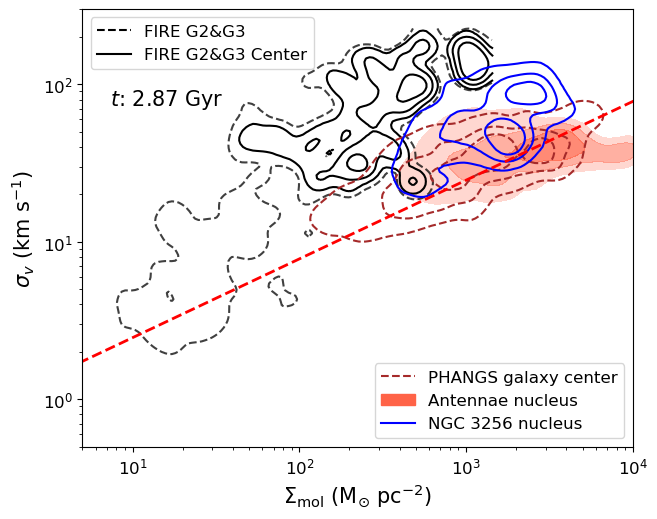

In [4]:
# load data and information for G2 galaxy
mom0file = fitsDir+'e2/losvd_FIRE2_e2_586_gas_v0__32_ccords_mom0.fits'
mom2file = fitsDir+'e2/losvd_FIRE2_e2_586_gas_v0__32_ccords_mom2.fits'
fitsfile = fitsDir+'e2/losvd_FIRE2_e2_586_gas_v0__32.fits'

def find_signal(fitsfile):
    '''
    Main body function to draw the contour
    '''
    # read the fits file

    data = fits.open(fitsfile)[0].data
    hdr = fits.open(fitsfile)[0].header
    data[np.where(data==0)] = np.nan

    # make moment maps
    mom0 = make_mom0(data)
    vel = np.arange(-500,500,2)
    mom2 = make_mom2(data, vel)

    counts = np.count_nonzero(~np.isnan(data),axis=2)
    mom0[np.where(mom0<1)] = np.nan
    mom2[np.where(counts<2)] = np.nan
    mask = np.ma.mask_or(np.isnan(mom0.flatten()), np.isnan(mom2.flatten()))

    # flag the nan values
    m0 = mom0.flatten()[np.where(~mask)]
    m2 = mom2.flatten()[np.where(~mask)]
    
    return m0, m2

def extract_center(mom0file, mom2file):
    # read the moment fits files
    wcs, mom0 = fits_import(mom0file)
    wcs, mom2 = fits_import(mom2file)

    # mask the region outside 1 kpc circle
    position = SkyCoord(ra=0, dec=0, unit='deg')
    central_sky = SkyCircularAperture(position, r=1*u.arcsec)
    central_pix = central_sky.to_pixel(wcs)
    mom0_center = Apmask_convert(central_pix, mom0)
    mom2_center = Apmask_convert(central_pix, mom2)
    
    return mom0_center, mom2_center

m0, m2 = find_signal(fitsfile)

mom0_center, mom2_center = extract_center(mom0file, mom2file)
# flag the nan values
mom2_center[np.where(mom2_center==0)] = np.nan
mask = np.isnan(mom2_center.flatten())
m0_center = mom0_center.flatten()[np.where(~mask)]
m2_center = mom2_center.flatten()[np.where(~mask)]
# flag the masked non-central region                                         
m0_center = m0_center.data[~m0_center.mask]
m2_center = m2_center.data[~m2_center.mask]                                         

levels = [0.2,0.5,0.8]
fig = plt.figure(figsize=(0.5*tex_textwidth,0.5*0.8*tex_textwidth))
ax=plt.subplot(111)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=5, right=1e4)
plt.ylim(bottom=0.5, top=300)
# plt.ylim(bottom=3, top=300)
plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma_v$ (km s$^{-1}$)',fontsize=15)
density_contour(m0, m2, weights=m0, levels=[0.8], ax=ax, color='black', linestyles='dashed',
                contour_type='contour')
density_contour(m0_center, m2_center, weights=m0_center, levels=levels, ax=ax, color='black',
                contour_type='contour',alphas=(1,1,1))
density_contour(table_center[7], table_center[8], weights=table_center[7],
                levels=levels,
                ax=ax, color='brown',
                contour_type='contour', linestyles='dashed',alphas=(1,1,1))
# Draw the contour plot for Antennae
density_contour(table_ant_center['surface_density'], table_ant_center['velocity_dispersion'],
                weights=table_ant_center['surface_density'], type='contour', levels=levels, ax=ax,
                color='tomato')
# Draw the contour plot for NGC3256
density_contour(table_3256_center['surface_density'], table_3256_center['velocity_dispersion'],
                weights=table_3256_center['surface_density'], contour_type='contour',
                levels=levels, ax=ax, color='blue', alphas=(1,1,1))
# Draw the virial parameter
ax.set_xlim(); ax.set_ylim()
Sigmol_theory = 10**np.linspace(-1,5,5)
vdep_theory = np.sqrt(Sigmol_theory * 3.1 / 5.77 * (45/40))
plt.plot(Sigmol_theory, vdep_theory, linestyle='--',linewidth=2,color='red')
# annotate the time and viewing angle
ax.annotate(r'$t$: 2.87 Gyr', (0.05, 0.78), 
             xycoords='axes fraction', fontsize=15)
# plot the legend
line_simul1 = mlines.Line2D([],[],color='black', linestyle='dashed', label='FIRE G2&G3')
line_simul2 = mlines.Line2D([],[],color='black', linestyle='solid', label='FIRE G2&G3 Center')
patch2 = mpatches.Patch(color='tomato', label=r'Antennae nucleus')
line2=mlines.Line2D([], [], color='blue', linestyle='solid', label=r'NGC 3256 nucleus')
line=mlines.Line2D([], [], color='brown', linestyle='dashed', label='PHANGS galaxy center')
legend = plt.legend(handles=[line_simul1, line_simul2],loc='upper left')
legend1 = plt.legend(handles=[line, patch2, line2], loc='lower right')
plt.gca().add_artist(legend)
plt.savefig('../Figures/Sigmol_vdep_central.pdf', bbox_inches='tight', pad_inches=0.2)

Show the spectrum for this snapshot

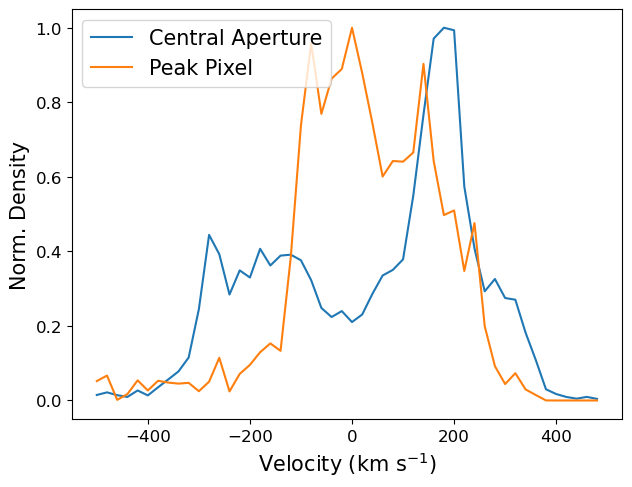

In [5]:
with open(logDir+'G2G3_e2_v0_587_central_spectrum.pkl', 'rb') as handle:
    central_spectrum = pickle.load(handle, encoding='latin')
with open(logDir+'G2G3_e2_v0_587_peak_spectrum.pkl', 'rb') as handle:
    peak_spectrum = pickle.load(handle, encoding='latin')
# bin the spectrum to 20 km/s per channel
central_spectrum_binned = np.average(central_spectrum.reshape(-1, 10), axis=1)
peak_spectrum_binned = np.average(peak_spectrum.reshape(-1, 10), axis=1)

vels = np.arange(-500, 500, 20)

fig = plt.figure(figsize=(0.5*tex_textwidth, 0.5*0.75*tex_textwidth))
plt.plot(vels, central_spectrum_binned/np.max(central_spectrum_binned), label='Central Aperture')
plt.plot(vels, peak_spectrum_binned/np.max(peak_spectrum_binned), label='Peak Pixel')
plt.xlabel('Velocity (km s$^{-1}$)', fontsize=15)
plt.ylabel('Norm. Density', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('../Figures/Central_spectrum.pdf', bbox_inches='tight', pad_inches=0.2)

In [6]:
aVir = 5.77 * m2**2 * m0**(-1) * (50/40)**(-1)
wq = DescrStatsW(data=aVir, weights=m0)
alphaVir_meds = wq.quantile(probs=[0.16, 0.5, 0.84], return_pandas=False)
print(alphaVir_meds)

[  7.78425229  64.56298161 181.69309682]


Try the center for the first snapshot. 

C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:249: UserWarning: The following kwargs were not used by contour: 'type'
  contourfunc(


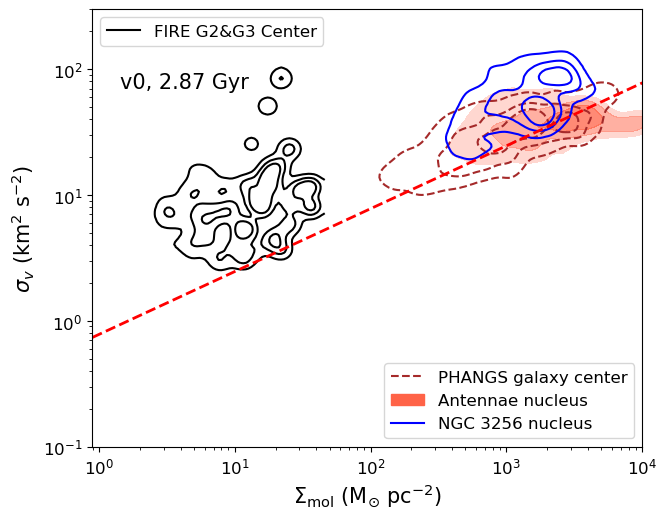

In [7]:
# load data and information for G2 galaxy
mom0file = fitsDir+'e2/losvd_FIRE2_e2_520_gas_v0__32_ccords_mom0.fits'
mom2file = fitsDir+'e2/losvd_FIRE2_e2_520_gas_v0__32_ccords_mom2.fits'

def extract_center(mom0file, mom2file):
    # read the moment fits files
    wcs, mom0 = fits_import(mom0file)
    wcs, mom2 = fits_import(mom2file)

    # mask the region outside 1 kpc circle
    position = SkyCoord(ra=0, dec=0, unit='deg')
    central_sky = SkyCircularAperture(position, r=1*u.arcsec)
    central_pix = central_sky.to_pixel(wcs)
    mom0_center = Apmask_convert(central_pix, mom0)
    mom2_center = Apmask_convert(central_pix, mom2)
    
    return mom0_center, mom2_center

mom0_center, mom2_center = extract_center(mom0file, mom2file)
# flag the nan values
mom2_center[np.where(mom2_center==0)] = np.nan
mask = np.isnan(mom2_center.flatten())
m0 = mom0_center.flatten()[np.where(~mask)]
m2 = mom2_center.flatten()[np.where(~mask)]
# flag the masked non-central region                                         
m0 = m0.data[~m0.mask]
m2 = m2.data[~m2.mask]                                         

levels = [0.2,0.5,0.8]
fig = plt.figure(figsize=(0.5*tex_textwidth,0.5*0.8*tex_textwidth))
ax=plt.subplot(111)
plt.xscale('log')
plt.yscale('log')
plt.xlim(right=1e4)
plt.ylim(bottom=0.1, top=300)
plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma_v$ (km$^2$ s$^{-2}$)',fontsize=15)           
density_contour(m0, m2, weights=m0, levels=levels, ax=ax, color='black',
                contour_type='contour',alphas=(1,1,1))
density_contour(table_center[7], table_center[8], weights=table_center[7],
                levels=levels,
                ax=ax, color='brown',
                contour_type='contour', linestyles='dashed',alphas=(1,1,1))
# Draw the contour plot for Antennae
density_contour(table_ant_center['surface_density'], table_ant_center['velocity_dispersion'],
                weights=table_ant_center['surface_density'], type='contour', levels=levels, ax=ax,
                color='tomato')
# Draw the contour plot for NGC3256
density_contour(table_3256_center['surface_density'], table_3256_center['velocity_dispersion'],
                weights=table_3256_center['surface_density'], contour_type='contour',
                levels=levels, ax=ax, color='blue', alphas=(1,1,1))
# Draw the virial parameter
ax.set_xlim(); ax.set_ylim()
Sigmol_theory = 10**np.linspace(-1,5,5)
vdep_theory = np.sqrt(Sigmol_theory * 3.1 / 5.77 * (45/40))
plt.plot(Sigmol_theory, vdep_theory, linestyle='--',linewidth=2,color='red')
# annotate the time and viewing angle
ax.annotate('v0, 2.87 Gyr', (0.05, 0.82), 
             xycoords='axes fraction', fontsize=15)
# plot the legend
line_simul = mlines.Line2D([],[],color='black', linestyle='solid', label='FIRE G2&G3 Center')
patch2 = mpatches.Patch(color='tomato', label=r'Antennae nucleus')
line2=mlines.Line2D([], [], color='blue', linestyle='solid', label=r'NGC 3256 nucleus')
line=mlines.Line2D([], [], color='brown', linestyle='dashed', label='PHANGS galaxy center')
legend = plt.legend(handles=[line_simul],loc='upper left')
legend1 = plt.legend(handles=[line, patch2, line2], loc='lower right')
plt.gca().add_artist(legend)
plt.savefig('../Figures/Sigmol_vdep_central_520.pdf', bbox_inches='tight', pad_inches=0.2)

Try for isolated galaxies

C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:249: UserWarning: The following kwargs were not used by contour: 'type'
  contourfunc(


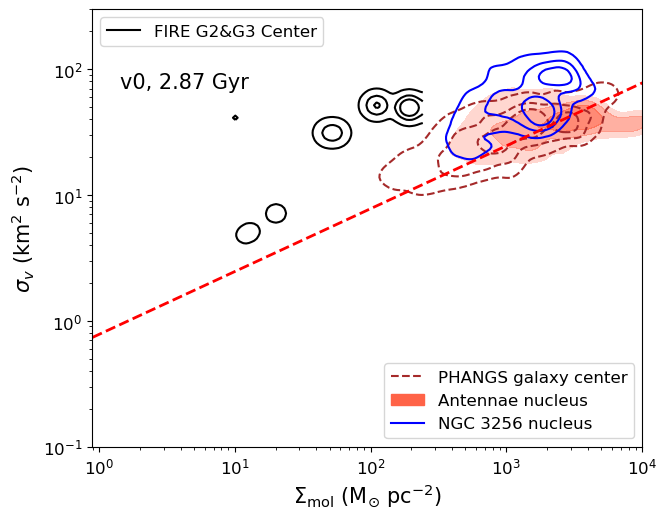

In [8]:
# load data and information for G2 galaxy
mom0file = 'losvd_FIRE2_i3_025_gas_pa30__32_ccords_mom0.fits'
mom2file = 'losvd_FIRE2_i3_025_gas_pa30__32_ccords_mom2.fits'

def extract_center(mom0file, mom2file):
    # read the moment fits files
    wcs, mom0 = fits_import(mom0file)
    wcs, mom2 = fits_import(mom2file)

    # mask the region outside 1 kpc circle
    position = SkyCoord(ra=0, dec=0, unit='deg')
    central_sky = SkyCircularAperture(position, r=1*u.arcsec)
    central_pix = central_sky.to_pixel(wcs)
    mom0_center = Apmask_convert(central_pix, mom0)
    mom2_center = Apmask_convert(central_pix, mom2)
    
    return mom0_center, mom2_center

mom0_center, mom2_center = extract_center(mom0file, mom2file)
# flag the nan values
mom2_center[np.where(mom2_center==0)] = np.nan
mask = np.isnan(mom2_center.flatten())
m0 = mom0_center.flatten()[np.where(~mask)]
m2 = mom2_center.flatten()[np.where(~mask)]
# flag the masked non-central region                                         
m0 = m0.data[~m0.mask]
m2 = m2.data[~m2.mask]                                         

levels = [0.2,0.5,0.8]
fig = plt.figure(figsize=(0.5*tex_textwidth,0.5*0.8*tex_textwidth))
ax=plt.subplot(111)
plt.xscale('log')
plt.yscale('log')
plt.xlim(right=1e4)
plt.ylim(bottom=0.1, top=300)
plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
plt.ylabel(r'$\sigma_v$ (km$^2$ s$^{-2}$)',fontsize=15)           
density_contour(m0, m2, weights=m0, levels=levels, ax=ax, color='black',
                contour_type='contour',alphas=(1,1,1))
density_contour(table_center[7], table_center[8], weights=table_center[7],
                levels=levels,
                ax=ax, color='brown',
                contour_type='contour', linestyles='dashed',alphas=(1,1,1))
# Draw the contour plot for Antennae
density_contour(table_ant_center['surface_density'], table_ant_center['velocity_dispersion'],
                weights=table_ant_center['surface_density'], type='contour', levels=levels, ax=ax,
                color='tomato')
# Draw the contour plot for NGC3256
density_contour(table_3256_center['surface_density'], table_3256_center['velocity_dispersion'],
                weights=table_3256_center['surface_density'], contour_type='contour',
                levels=levels, ax=ax, color='blue', alphas=(1,1,1))
# Draw the virial parameter
ax.set_xlim(); ax.set_ylim()
Sigmol_theory = 10**np.linspace(-1,5,5)
vdep_theory = np.sqrt(Sigmol_theory * 3.1 / 5.77 * (45/40))
plt.plot(Sigmol_theory, vdep_theory, linestyle='--',linewidth=2,color='red')
# annotate the time and viewing angle
ax.annotate('v0, 2.87 Gyr', (0.05, 0.82), 
             xycoords='axes fraction', fontsize=15)
# plot the legend
line_simul = mlines.Line2D([],[],color='black', linestyle='solid', label='FIRE G2&G3 Center')
patch2 = mpatches.Patch(color='tomato', label=r'Antennae nucleus')
line2=mlines.Line2D([], [], color='blue', linestyle='solid', label=r'NGC 3256 nucleus')
line=mlines.Line2D([], [], color='brown', linestyle='dashed', label='PHANGS galaxy center')
legend = plt.legend(handles=[line_simul],loc='upper left')
legend1 = plt.legend(handles=[line, patch2, line2], loc='lower right')
plt.gca().add_artist(legend)
plt.savefig('../Figures/Sigmol_vdep_central_G3_025.pdf', bbox_inches='tight', pad_inches=0.2)

## Make the plot for 3 snapshots in the paper

In [9]:
def draw_contour(ax, orbit, incl, idNo):
    '''
    Main body function to draw the contour
    '''
    # read the fits file
    fitsfile = fitsDir+orbit+'/losvd_FIRE2_'+orbit+'_'+str(idNo)+'_gas_'+str(incl)+'__32.fits'
    data = fits.open(fitsfile)[0].data
    hdr = fits.open(fitsfile)[0].header
    data[np.where(data==0)] = np.nan

    # make moment maps
    mom0 = make_mom0(data)
    vel = np.arange(-500,500,2)
    mom1 = make_mom1(data, vel)
    mom2 = make_mom2(data, vel)
    Tpeak = make_Tpeak(data)

    counts = np.count_nonzero(~np.isnan(data),axis=2)
    mom0[np.where(mom0<1)] = np.nan
    mom2[np.where(counts<2)] = np.nan
    mask = np.ma.mask_or(np.isnan(mom0.flatten()), np.isnan(mom2.flatten()))

    # flag the nan values
    m1 = mom0.flatten()[np.where(~mask)]
    m2 = mom2.flatten()[np.where(~mask)]
    # make the scatter plot
    plt.xscale('log')
    plt.yscale('log')

#     plt.xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
    plt.ylabel(r'$\sigma_v$ (km s$^{-1}$)',fontsize=15)

    # Draw the scatter and contour plot for simulation 
    levels = [0.2, 0.5, 0.8]
#     plt.scatter(mom0.flatten(), mom2.flatten(), alpha=0.05, color='gray')
    density_contour(m1, m2, weights=m1, levels=levels, ax=ax, color='black',
                    contour_type='contour',alphas=(1,1,1))
    plt.ylim(bottom=0.1)
    plt.ylim(top=250)

    # Draw the contour plot for PHANGS data
    density_contour(table_90pc[7], table_90pc[8], weights=table_90pc[7], levels=levels,
                    ax=ax, color='tab:blue')
    # Draw the virial parameter
    ax.set_xlim(); ax.set_ylim()
    Sigmol_theory = 10**np.linspace(-1,5,5)
    vdep_theory = np.sqrt(Sigmol_theory * 3.1 / 5.77 * (45/40))
    plt.plot(Sigmol_theory, vdep_theory, linestyle='--',linewidth=2,color='red')

    # Draw the contour plot for Antennae
    density_contour(table_ant_90pc['surface_density'], table_ant_90pc['velocity_dispersion'],
                    weights=table_ant_90pc['surface_density'], type='contour', levels=levels, ax=ax,
                    color='tomato')
#    density_contour(table_ant_90pc['surface_density']/4, table_ant_90pc['velocity_dispersion'],
#                     weights=table_ant_90pc['surface_density']/4, contour_type='contour',
#                     levels=levels, ax=ax, color='orangered', linestyles='solid', alphas=(1,1,1))
    # Draw the contour plot for NGC3256
    density_contour(table_3256_80pc['surface_density'], table_3256_80pc['velocity_dispersion'],
                    weights=table_3256_80pc['surface_density'], contour_type='contour',
                    levels=levels, ax=ax, color='blue', alphas=(1,1,1))
    # Draw the contour plot for M31 and M33
    density_contour(table_M31[3], table_M31[4], weights=table_M31[3], levels=levels,
                    ax=ax, contour_type='contour', alphas=(1,1,1), color='green')
    # label the legend
    line_simul = mlines.Line2D([],[],color='black', linestyle='solid', label='FIRE G2&G3')
    patch = mpatches.Patch(color='tab:blue', label='PHANGS galaxies')
    patch2 = mpatches.Patch(color='tomato', label=r'Antennae, $\alpha_{\mathrm{CO}}=4.3$')
#    line=mlines.Line2D([], [], color='tomato', linestyle='solid', label=r'Antennae, $\alpha_{\mathrm{CO}}=4.3$')
    line2=mlines.Line2D([], [], color='blue', linestyle='solid', label=r'NGC 3256, $\alpha_{\mathrm{CO}}=1.1$')
    line3=mlines.Line2D([], [], color='green', linestyle='solid', label='M31')
    legend = plt.legend(handles=[line_simul],loc='upper left', fontsize=12)
    legend1 = plt.legend(handles=[patch, patch2, line2, line3], loc='lower right', fontsize=12, framealpha=0.5)
    plt.gca().add_artist(legend)
    
    return

def make_moments(ax, orbit, incl, idNo):
    '''
    Make the moment maps for different snapshots
    '''
    # read the fits file
    fitsfile = fitsDir+orbit+'/losvd_FIRE2_'+orbit+'_'+str(idNo)+'_gas_'+str(incl)+'__32.fits'
    data = fits.open(fitsfile)[0].data
    hdr = fits.open(fitsfile)[0].header
    data[np.where(data==0)] = np.nan
    
    # zoom into the central region
    FOV = np.array([10,10]) # in kpc
    data = data[int(124-FOV[0]/2*10):int(124+FOV[0]/2*10), int(124-FOV[1]/2*10):int(124+FOV[1]/2*10), :]
    extent=[-FOV[0]/2, FOV[0]/2, -FOV[1]/2, FOV[1]/2]

#     # set the color bar
#     colors1 = plt.cm.binary(np.linspace(0., 1, 128))
#     colors2 = plt.cm.gist_heat(np.linspace(0, 1, 128))
#     colors_combined = np.vstack((colors1, colors2))
#     mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors_combined)

    # make moment maps
    mom0 = make_mom0(data)
    counts = np.count_nonzero(~np.isnan(data),axis=2)
    mask1 = mom0<1; mask2 = counts<2
    mask = np.ma.mask_or(mask1, mask2, copy=True)
    mom0[mask] = np.nan
#     vel = np.arange(-500,500,2)
#     mom1 = make_mom1(data, vel)
#     mom2 = make_mom2(data, vel)
#     Tpeak = make_Tpeak(data)

    # plot the moment maps
    vmax = np.nanpercentile(mom0.flatten(), 99.5)
#     vmin = np.nanpercentile(mom0.flatten(), 0.5)
    vmin = vmax/100
#     ax.set_title('Moment 0 Map', fontsize=15)
    ax.tick_params(direction='in')
    im = ax.imshow(mom0, origin='lower', cmap='gist_heat_r',
                   norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                   extent=extent)
#     ax.set_xlabel('kpc', fontsize=15)
#     ax.set_ylabel('kpc', fontsize=15)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='5%', pad=0.05)
#     cax = fig.add_axes([ax.get_position().x0, ax.get_position().y1, 0.8*(ax.get_position().x1-ax.get_position().x0), 0.01])
    cbar = plt.colorbar(im, orientation='horizontal', cax=cax)
#     cax.set_xlabel(r'M$_{\odot}$ pc$^{-2}$', fontsize=15,loc='right', labelpad=-15)
    cax.get_xaxis().set_ticks_position('top')
#     cax.xaxis.set_label_position('top')

    # annotate with the plots
    ax.annotate('$\Sigma_{\mathrm{mol}}$\n(M$_{\odot}$ pc$^{-2}$)', (0.08,0.85), xycoords='axes fraction', fontsize=15,
               ha='left', va='center') 

    # draw the red aperture around the center with diameter of 1 kpc
#     if draw_aperture == True:
    circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linewidth=2)
    ax.add_patch(circle)

    
    return

def make_alphavir_maps(ax, orbit, incl, idNo):
    '''
    Make the virial parameter maps for different snapshots
    '''
    # read the fits file
    fitsfile = fitsDir+orbit+'/losvd_FIRE2_'+orbit+'_'+str(idNo)+'_gas_'+str(incl)+'__32.fits'
    data = fits.open(fitsfile)[0].data
    hdr = fits.open(fitsfile)[0].header
    data[np.where(data==0)] = np.nan
    
    # zoom into the central region
    FOV = np.array([10,10]) # in kpc
    data = data[int(124-FOV[0]/2*10):int(124+FOV[0]/2*10), int(124-FOV[1]/2*10):int(124+FOV[1]/2*10), :]
    extent=[-FOV[0]/2, FOV[0]/2, -FOV[1]/2, FOV[1]/2]
    
    # make moment maps
    mom0 = make_mom0(data)
    vel = np.arange(-500,500,2)
    mom2 = make_mom2(data, vel)
    # mask values
    counts = np.count_nonzero(~np.isnan(data),axis=2)
    mask1 = mom0<1; mask2 = counts<2
    mask = np.ma.mask_or(mask1, mask2, copy=True)
    m0 = mom0[~mask].flatten()
    m2 = mom2[~mask].flatten()
    # calculate the virial parameters
    alphaVir = 5.77 * mom2**2 * mom0**(-1) * (50/40)**(-1)
    alphaVir[mask] = np.nan
    aVir = alphaVir[~mask].flatten()
    wq = DescrStatsW(data=aVir, weights=m0)
    aVir_percentiles = wq.quantile(probs=[0.16, 0.84], return_pandas=False)
    vmin = 1; vmax = 100
#     vmin = aVir_percentiles[0]; vmax = aVir_percentiles[1]
    # make plots
    ax.tick_params(direction='in')
    im = ax.imshow(alphaVir, origin='lower', cmap='coolwarm',
                   norm=colors.LogNorm(vmin=vmin, vmax=vmax),
#                    vmin = np.nanmin(aVir), vmax=vmax, 
                   extent=extent)
#     ax.set_xlabel('kpc', fontsize=15)
    ax.tick_params(labelleft=False)
    # add the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='5%', pad=0.05)
    cbar = plt.colorbar(im, orientation='horizontal', cax=cax)
    cax.get_xaxis().set_ticks_position('top')
    # annotate with the plots
    ax.annotate(r'$\alpha_{\mathrm{vir}}$', (0.08,0.9), xycoords='axes fraction', fontsize=15,
               ha='left', va='center') 

    # draw circle around the center
    circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linewidth=2)
    ax.add_patch(circle)
    
    return

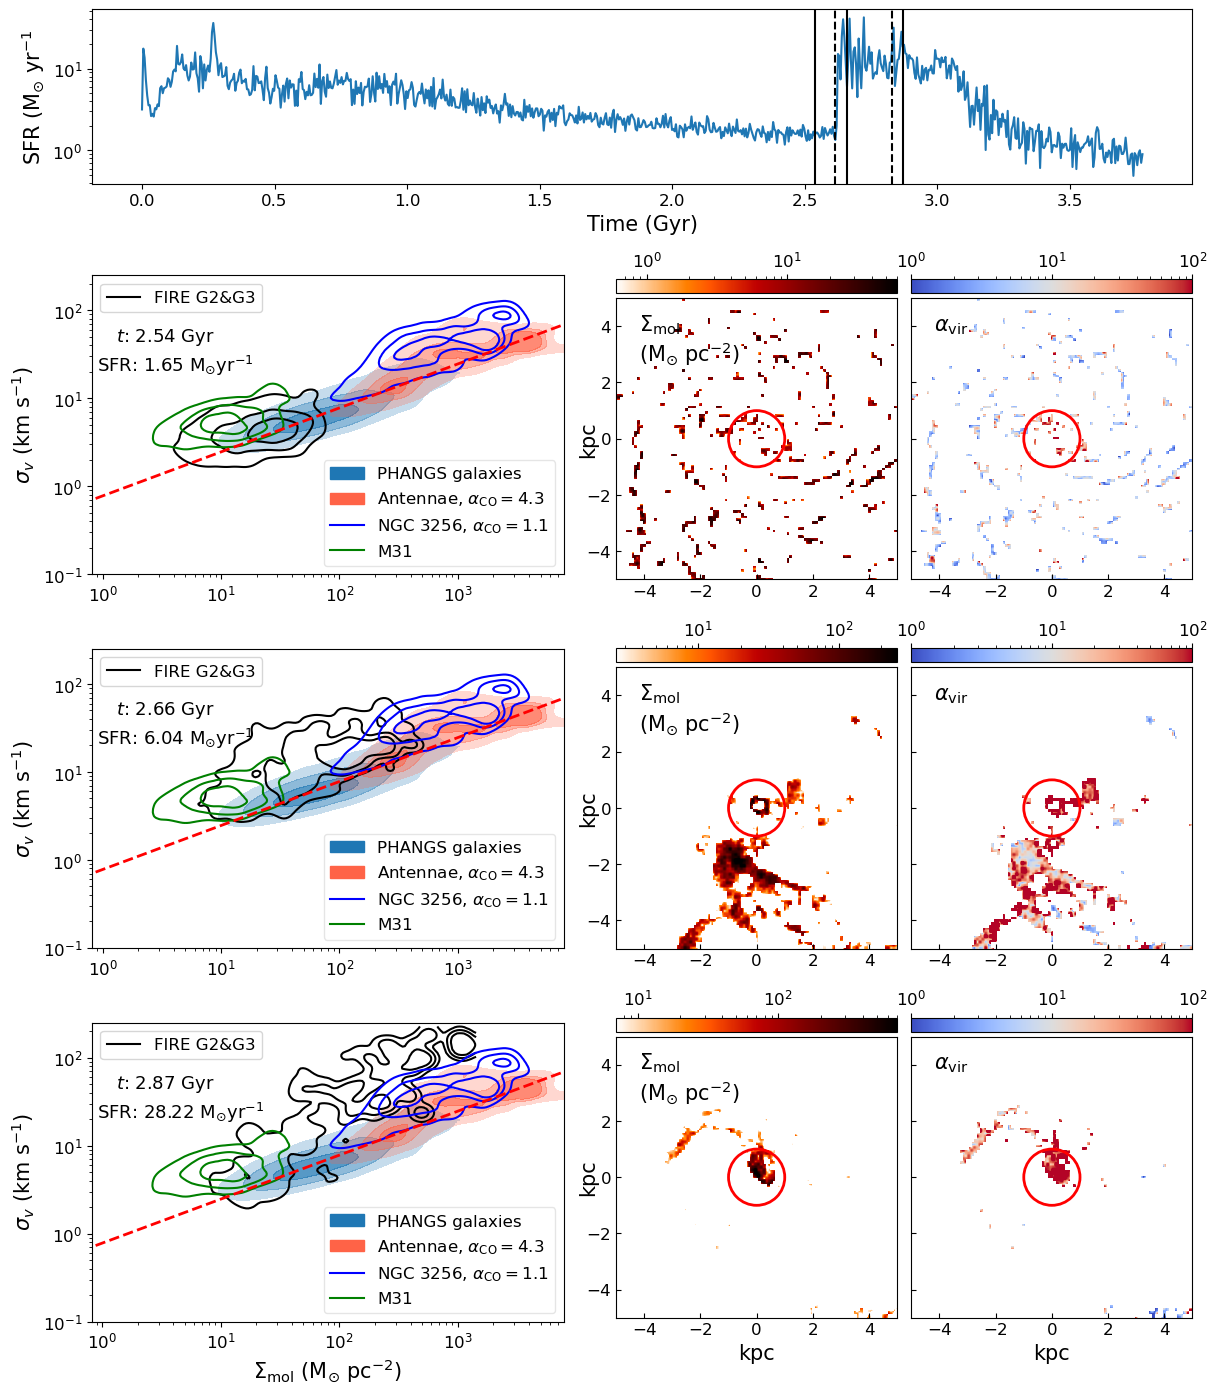

In [10]:
%%capture --no-display
fig = plt.figure(figsize=(tex_textwidth, 1.2*tex_textwidth))
gc = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, height_ratios=[0.5, 3],
                        hspace=0.15)
gc1 = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, subplot_spec=gc[1], width_ratios=[4.5,5.5],
                                       hspace=0.2, wspace=0.1)
gc1_scatter = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=3, subplot_spec=gc1[0], hspace=0.25)
gc1_maps = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=3, subplot_spec=gc1[1], wspace=0.05)

# plot the SFR history for 'e2' orbit
filename=npzDir+'galsep_G2G3_e_orbit_2.npz'
data = np.load(filename)
SFRs = data['sfr']
Times = data['time']
Snapshots = data['isnap']
ax = fig.add_subplot(gc[0])
ax.set_yscale('log')
ax.plot(Times, SFRs)
ax.set_xlabel('Time (Gyr)', fontsize=15)
ax.set_ylabel('SFR (M$_{\odot}$ yr$^{-1}$', fontsize=15)
ax.axvline(2.616, linestyle='dashed', color='black')
ax.axvline(2.831, linestyle='dashed', color='black')
ax.axvline(2.54, linestyle='solid', color='black')
ax.axvline(2.66, linestyle='solid', color='black')
ax.axvline(2.87, linestyle='solid', color='black')

orbit = 'e2'; incl = 'v0'; ids = [520, 544, 586]
times = [2.54, 2.66, 2.87]
sfrs = np.round(np.array([SFRs[520],SFRs[544],SFRs[586]]),2)
for i, idNo in enumerate(ids):
    # plot the scatter plot
    ax = fig.add_subplot(gc1_scatter[i])
    draw_contour(ax, orbit, incl, idNo)
    ax.annotate('$t$: '+str(times[i])+' Gyr', (0.05, 0.78), 
         xycoords='axes fraction', fontsize=13)
    ax.annotate('SFR: '+str(sfrs[i])+' M$_{\odot}$yr$^{-1}$', (0.01, 0.68), 
         xycoords='axes fraction', fontsize=13)
    if i==2:
        ax.set_xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
    # plot maps
    ax = fig.add_subplot(gc1_maps[i,0])
    ax.set_ylabel('kpc', fontsize=15, labelpad=-8)
    make_moments(ax, orbit, incl, idNo)
    if i==2:
        ax.set_xlabel('kpc',fontsize=15)
    ax = fig.add_subplot(gc1_maps[i,1])
    make_alphavir_maps(ax, orbit, incl, idNo)
    if i==2:
        ax.set_xlabel('kpc',fontsize=15)
    # axes[n][6] = fig.add_subplot(gc_cbar[0,n])
plt.savefig(figDir+'G2G3_e2_examples.pdf',bbox_inches='tight',pad_inches=0.1)

Make one snapshot at 2.87 Gyr viewed from v1 angle

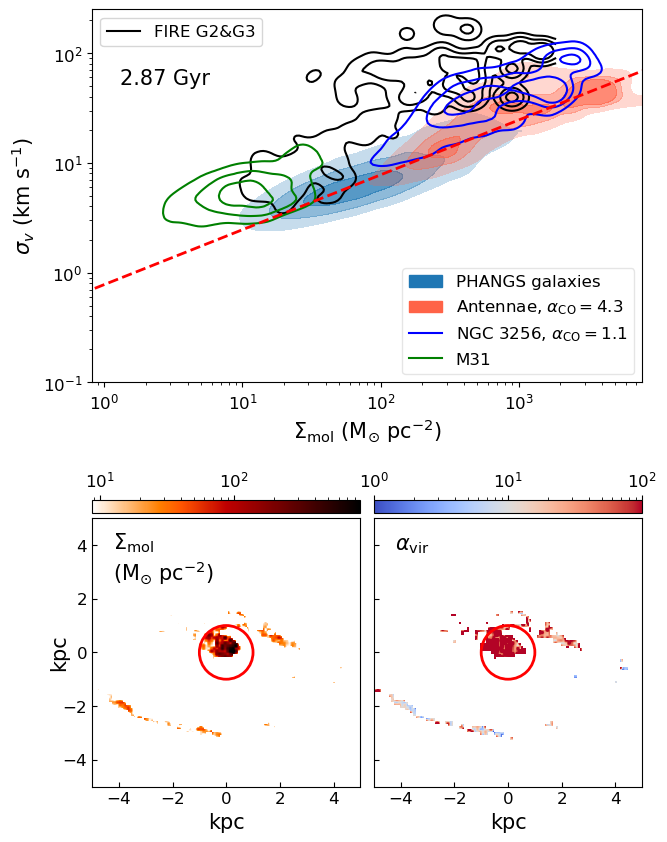

In [11]:
%%capture --no-display
orbit = "e2"; incl = "v1"; idNo = 586

fig = plt.figure(figsize=(0.5*tex_textwidth, 0.75*tex_textwidth))
gc = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, height_ratios=[1, 1],
                        hspace=0.2)
# plot the scatter plot
ax = fig.add_subplot(gc[0])
draw_contour(ax, orbit, incl, idNo) 
ax.set_xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
ax.annotate('2.87 Gyr', (0.05, 0.8), 
     xycoords='axes fraction', fontsize=15)

gc_maps = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, subplot_spec=gc[1], wspace=0.05)
# plot the surface density maps
ax = fig.add_subplot(gc_maps[0])
ax.set_ylabel('kpc', fontsize=15, labelpad=-5)
make_moments(ax, orbit, incl, idNo)
ax.set_xlabel('kpc',fontsize=15)
# plot the virial parameter maps
ax = fig.add_subplot(gc_maps[1])
make_alphavir_maps(ax, orbit, incl, idNo)
ax.set_xlabel('kpc',fontsize=15)
plt.savefig(figDir+'G2G3_e2_v1_586.pdf',bbox_inches='tight',pad_inches=0.1)

Three snapshots for `e1' orbit

In [12]:
print(np.where(np.round(Times,2)==1.56))
print(Times[320])

(array([318, 319, 320], dtype=int64),)
1.5647999978139997


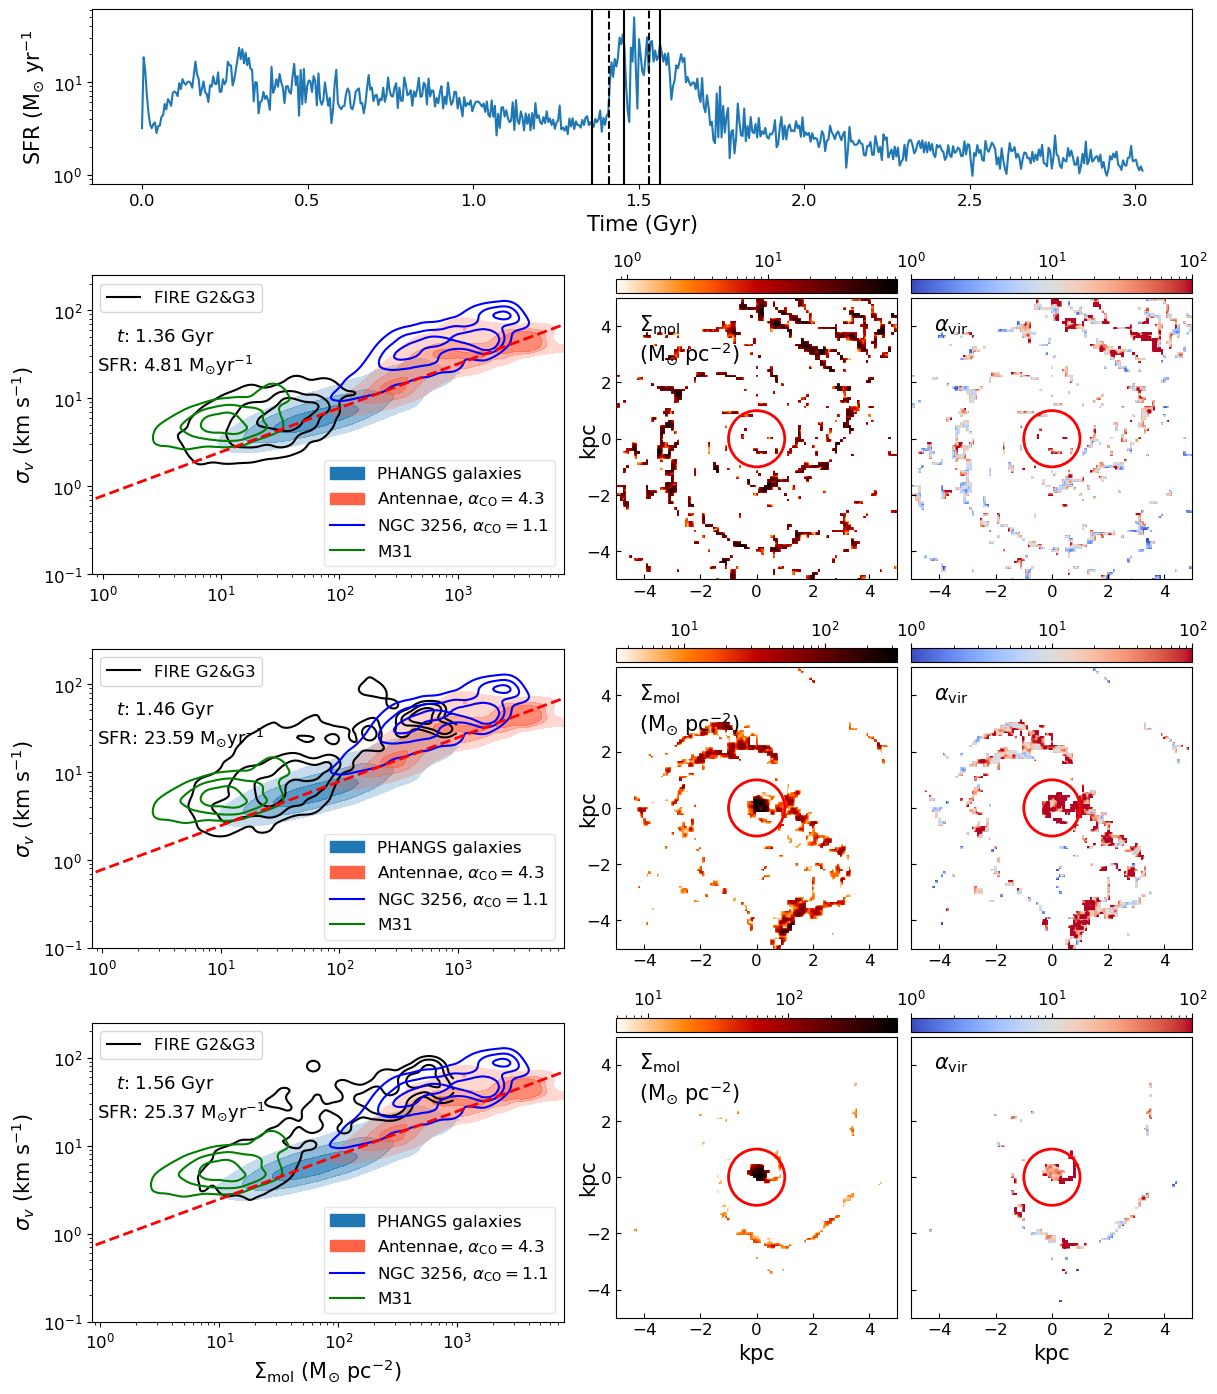

In [18]:
%%capture --no-display
fig = plt.figure(figsize=(tex_textwidth, 1.2*tex_textwidth))
gc = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, height_ratios=[0.5, 3],
                        hspace=0.15)
gc1 = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, subplot_spec=gc[1], width_ratios=[4.5,5.5],
                                       hspace=0.2, wspace=0.1)
gc1_scatter = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=3, subplot_spec=gc1[0], hspace=0.25)
gc1_maps = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=3, subplot_spec=gc1[1], wspace=0.05)

# plot the SFR history for 'e2' orbit
filename=npzDir+'galsep_G2G3_e_orbit_1.npz'
data = np.load(filename)
SFRs = data['sfr']
Times = data['time']
Snapshots = data['isnap']
ax = fig.add_subplot(gc[0])
ax.set_yscale('log')
ax.plot(Times, SFRs)
ax.set_xlabel('Time (Gyr)', fontsize=15)
ax.set_ylabel('SFR (M$_{\odot}$ yr$^{-1}$', fontsize=15)
# plot the time for second enounter and final coalesce
ax.axvline(1.41, linestyle='dashed', color='black')
ax.axvline(1.53, linestyle='dashed', color='black')
ax.axvline(Times[278], linestyle='solid', color='black')
ax.axvline(Times[298], linestyle='solid', color='black')
ax.axvline(Times[320], linestyle='solid', color='black')

orbit = 'e1'; incl = 'v0'; ids = [278, 298, 320]
times = np.round(np.array([Times[278],Times[298],Times[320]]),2)
sfrs = np.round(np.array([SFRs[250],SFRs[298],SFRs[320]]),2)
for i, idNo in enumerate(ids):
    # plot the scatter plot
    ax = fig.add_subplot(gc1_scatter[i])
    draw_contour(ax, orbit, incl, idNo)
    ax.annotate('$t$: '+str(times[i])+' Gyr', (0.05, 0.78), 
         xycoords='axes fraction', fontsize=13)
    ax.annotate('SFR: '+str(sfrs[i])+' M$_{\odot}$yr$^{-1}$', (0.01, 0.68), 
         xycoords='axes fraction', fontsize=13)
    if i==2:
        ax.set_xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
    # plot maps
    ax = fig.add_subplot(gc1_maps[i,0])
    ax.set_ylabel('kpc', fontsize=15, labelpad=-8)
    make_moments(ax, orbit, incl, idNo)
    if i==2:
        ax.set_xlabel('kpc',fontsize=15)
    ax = fig.add_subplot(gc1_maps[i,1])
    make_alphavir_maps(ax, orbit, incl, idNo)
    if i==2:
        ax.set_xlabel('kpc',fontsize=15)
    # axes[n][6] = fig.add_subplot(gc_cbar[0,n])
plt.savefig(figDir+'G2G3_e1_examples.pdf',bbox_inches='tight',pad_inches=0.1)

#### For postdoc job application

C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:87: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:103: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:107: RuntimeWarning: invalid value encountered in true_divide
  mom2 = np.sqrt(np.nansum(vel_diff**2*dataCubes,axis=2) / np.nansum(dataCubes,axis=2))
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:128: RuntimeWarning: All-NaN slice encountered
  mom8 = np.nanmax(dataCubes, axis=2)*value/pixsize**2
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:249: UserWarning: The following kwargs were not used by contour: 'type'
  contourfunc(


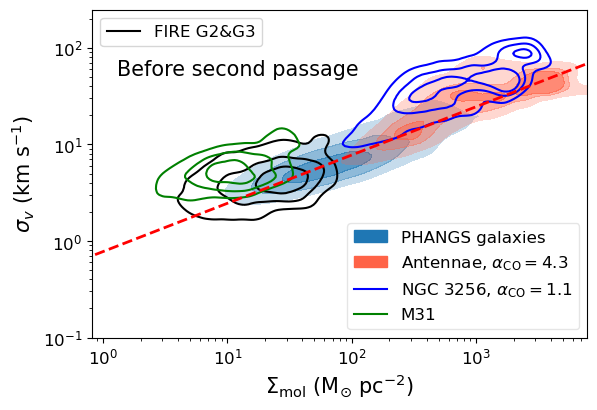

In [14]:
orbit = "e2"; incl = "v0"; idNo = 520 # 544

fig = plt.figure(figsize=(0.45*tex_textwidth, 0.3*tex_textwidth))
ax =plt.subplot(111)
draw_contour(ax, orbit, incl, idNo) 
ax.set_xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
# ax.annotate('2.54 Gyr', (0.05, 0.75), 
#      xycoords='axes fraction', fontsize=15)
ax.annotate('Before second passage', (0.05, 0.8), 
     xycoords='axes fraction', fontsize=15)
plt.savefig(figDir+'Sigmol_vdep_e2_v0_520.png',bbox_inches='tight', dpi=300)

C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:87: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:103: RuntimeWarning: invalid value encountered in true_divide
  mom1 = np.nansum(vel_3d*dataCubes,axis=2) / np.nansum(dataCubes,axis=2)
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:107: RuntimeWarning: invalid value encountered in true_divide
  mom2 = np.sqrt(np.nansum(vel_diff**2*dataCubes,axis=2) / np.nansum(dataCubes,axis=2))
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:128: RuntimeWarning: All-NaN slice encountered
  mom8 = np.nanmax(dataCubes, axis=2)*value/pixsize**2
C:\Users\haohe\AppData\Local\Temp\ipykernel_11788\2992579412.py:249: UserWarning: The following kwargs were not used by contour: 'type'
  contourfunc(


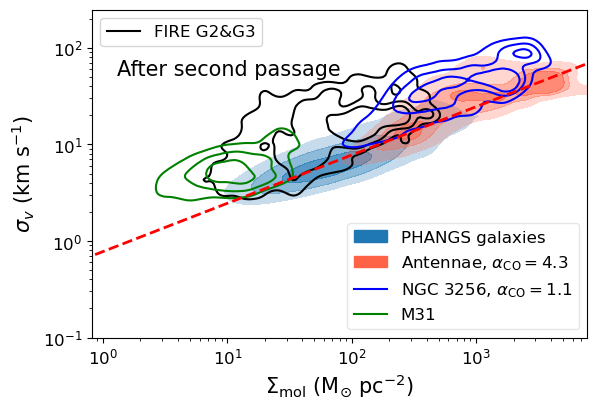

In [15]:
orbit = "e2"; incl = "v0"; idNo = 544

fig = plt.figure(figsize=(0.45*tex_textwidth, 0.3*tex_textwidth))
ax =plt.subplot(111)
draw_contour(ax, orbit, incl, idNo) 
ax.set_xlabel('$\Sigma_{\mathrm{mol}}$ (M$_{\odot}$ pc$^{-2}$)',fontsize=15)
# ax.annotate('2.66 Gyr', (0.05, 0.75), 
#      xycoords='axes fraction', fontsize=15)
ax.annotate('After second passage', (0.05, 0.8), 
     xycoords='axes fraction', fontsize=15)
plt.savefig(figDir+'Sigmol_vdep_e2_v0_544.png',bbox_inches='tight', dpi=300)

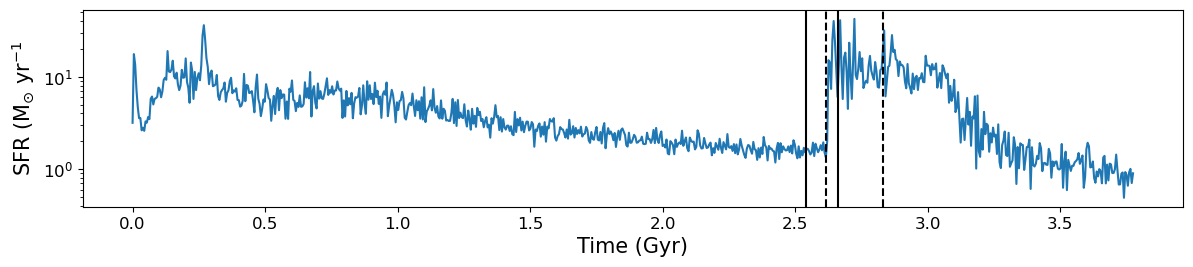

In [16]:
# plot the SFR history for 'e2' orbit
filename=npzDir+'galsep_G2G3_e_orbit_2.npz'
data = np.load(filename)
SFRs = data['sfr']
Times = data['time']
Snapshots = data['isnap']
fig = plt.figure(figsize=(1.0*tex_textwidth, 0.18*tex_textwidth))
ax = plt.subplot(111)
ax.set_yscale('log')
ax.plot(Times, SFRs)
ax.set_xlabel('Time (Gyr)', fontsize=15)
ax.set_ylabel('SFR (M$_{\odot}$ yr$^{-1}$', fontsize=15)
ax.axvline(2.616, linestyle='dashed', color='black')
ax.axvline(2.831, linestyle='dashed', color='black')
ax.axvline(2.54, linestyle='solid', color='black')
ax.axvline(2.66, linestyle='solid', color='black')
# ax.axvline(2.87, linestyle='solid', color='black')
plt.savefig(figDir+'SFH.png',bbox_inches='tight', dpi=300)